Volatility-Regime Trading Strategy Specification 
#### Volatility Forecasting (Predicted Volatility)

Use a GARCH(1,1) model to estimate the market volatility for the next day:

- Input: daily returns

- Output: Estimated Volatility $\hat{\sigma}_{t+1}$

This predicted volatility will be used to determine which trading regime the market is currently in.

#### Regime Classification (Volatility-Based Regime Switching)

Define a volatility threshold:

If Predicted Volatility > Threshold
→ Market is in a High-Volatility Regime
→ Apply Mean Reversion Strategy (RSI)

If Predicted Volatility ≤ Threshold
→ Market is in a Low-Volatility Regime
→ Apply Momentum Strategy (SMA Crossover)

#### Strategy Rules for Each Regime
A. High-Volatility Regime → Mean Reversion (RSI-Based)

When predicted volatility is high, price tends to overshoot → revert.

Signals:

- RSI < Oversold Level → Buy (Long)
- RSI > Overbought Level → Sell (Short)

parameters:
RSI(14), Oversold = 30, Overbought = 70 

B. Low-Volatility Regime → Momentum (SMA Crossover)

When volatility is low, trends tend to persist → momentum.

Signals:
- Short SMA crosses above Long SMA → Buy (Long)
- Short SMA crosses below Long SMA → Sell (Short)

Typical parameters:
Short SMA = 20, Long SMA = 50 (configurable)

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [91]:
import pandas as pd
import numpy as np
import processing_data as pr
import feature_engineer as fe 
import data_generator as dg
import detect_and_handle_outlier as outlier
import matplotlib.pyplot as plt
from arch import arch_model


In [92]:
csv_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\stocks_data\AAPL.csv"
SP_500_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\S&P_500"
df_SP500 = pd.read_csv(SP_500_path)
df = pr.load_data(csv_path)
df

,date,ticker,adj_close,close,high,low,open,volume
0,2015-01-02,AAPL,24.237545,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-05,AAPL,23.554737,26.562500,27.162500,26.352501,27.072500,257142000.0
2,2015-01-06,AAPL,23.556955,26.565001,26.857500,26.157499,26.635000,263188400.0
3,2015-01-07,AAPL,23.887274,26.937500,27.049999,26.674999,26.799999,160423600.0
4,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0
...,...,...,...,...,...,...,...,...
2697,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0
2698,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0
2699,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0
2700,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0


In [93]:
df_SP500['date'] = pd.to_datetime(df_SP500['date'])

In [94]:
df_SP500 = fe.add_lagged_log_returns(df_SP500, "close", no_max_lags=0)
df_SP500

,date,ticker,close,high,low,open,volume,close_log_return
0,2015-01-02,^GSPC,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,NaN
1,2015-01-05,^GSPC,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2,2015-01-06,^GSPC,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
3,2015-01-07,^GSPC,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
4,2015-01-08,^GSPC,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
...,...,...,...,...,...,...,...,...
2697,2025-09-24,^GSPC,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,-0.002851
2698,2025-09-25,^GSPC,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,-0.005022
2699,2025-09-26,^GSPC,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,0.005884
2700,2025-09-29,^GSPC,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,0.002632


#### Preprocesing Data

- Sort & deduplicate
- Check OHLCV sanity
- Check missing value

In [95]:
df = pr.sort_and_deduplicate(df)
df_bad = pr.check_ohlcv_sanity(df)
df_bad

,date,ticker,adj_close,close,high,low,open,volume


In [96]:
pr.check_missing_values(df)

No Missing value


In [97]:
# add close log return and features
features = ["MA_50", "RSI_14"]

df = fe.add_lagged_log_returns(df, "close", no_max_lags=0).dropna().reset_index(drop=True)
df = fe.add_features(df,features_pool=features).dropna().reset_index(drop=True)
df["close_log_return_pct"] = df["close_log_return"]*100
df

,date,ticker,adj_close,close,high,low,open,volume,close_log_return,MA_50,RSI_14,close_log_return_pct
0,2015-03-18,AAPL,28.593136,32.117500,32.290001,31.592501,31.750000,261083600.0,0.011193,30.003150,45.533452,1.119342
1,2015-03-19,AAPL,28.377245,31.875000,32.312500,31.850000,32.187500,183238000.0,-0.007579,30.114250,44.971639,-0.757906
2,2015-03-20,AAPL,28.021137,31.475000,32.099998,31.290001,32.062500,274780400.0,-0.012628,30.220450,47.391285,-1.262841
3,2015-03-23,AAPL,28.312698,31.802500,31.962500,31.629999,31.780001,150838800.0,0.010351,30.311200,41.765631,1.035130
4,2015-03-24,AAPL,28.196960,31.672501,32.009998,31.639999,31.807501,131369200.0,-0.004096,30.387800,44.732969,-0.409608
...,...,...,...,...,...,...,...,...,...,...,...,...
2646,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0,-0.008367,225.743600,66.814153,-0.836724
2647,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0,0.017912,226.607599,62.979078,1.791162
2648,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0,-0.005504,227.541799,66.287444,-0.550423
2649,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0,-0.004040,228.450599,66.794047,-0.404015


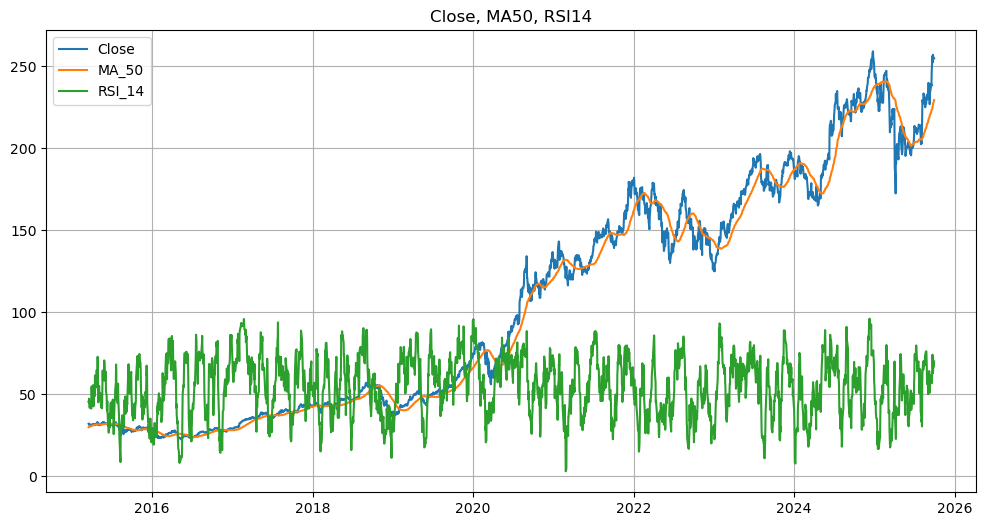

In [98]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["close"], label="Close")
plt.plot(df["date"], df["MA_50"], label="MA_50")
plt.plot(df["date"], df["RSI_14"], label="RSI_14")
plt.legend()
plt.grid(True)
plt.title("Close, MA50, RSI14")
plt.show()

In [99]:
# Handle outlier 
df = outlier.winsorize(df, "close_log_return_pct")

In [100]:
window_size = 252
forecast_vol = []

for i in range(window_size,len(df)):
    train_returns = df['close_log_return_pct'].iloc[i-window_size:i]

    model = arch_model(train_returns, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    res = model.fit(disp='off')

    # Dự báo variance cho t+1
    forecast = res.forecast(horizon=1)
    var_next = forecast.variance.iloc[-1, 0]

    # Lưu Volatility (Std Dev)
    forecast_vol.append(np.sqrt(var_next))

In [101]:
trade_results = df.iloc[window_size:].copy()
trade_results['garch_vol'] = forecast_vol

In [102]:
# Momentum signals
trade_results['signal_momentum'] = np.where(trade_results['close'] > trade_results['MA_50'], 1, -1)

# Mean-Reversion signals
trade_results.loc[trade_results['RSI_14'] < 30, 'signal_mean_rev'] = 1
trade_results.loc[trade_results['RSI_14'] > 70, 'signal_mean_rev'] = -1
trade_results['signal_mean_rev'] = trade_results['signal_mean_rev'].replace(0, method='ffill').fillna(0)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8636\1479402650.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  trade_results['signal_mean_rev'] = trade_results['signal_mean_rev'].replace(0, method='ffill').fillna(0)


In [103]:
trade_results['vol_threshold'] = trade_results['garch_vol'].rolling(63).mean().shift(1)

In [104]:
trade_results['final_signal'] = np.where(
    trade_results['garch_vol'] > trade_results['vol_threshold'],
    trade_results['signal_mean_rev'], 
    trade_results['signal_momentum']  
)

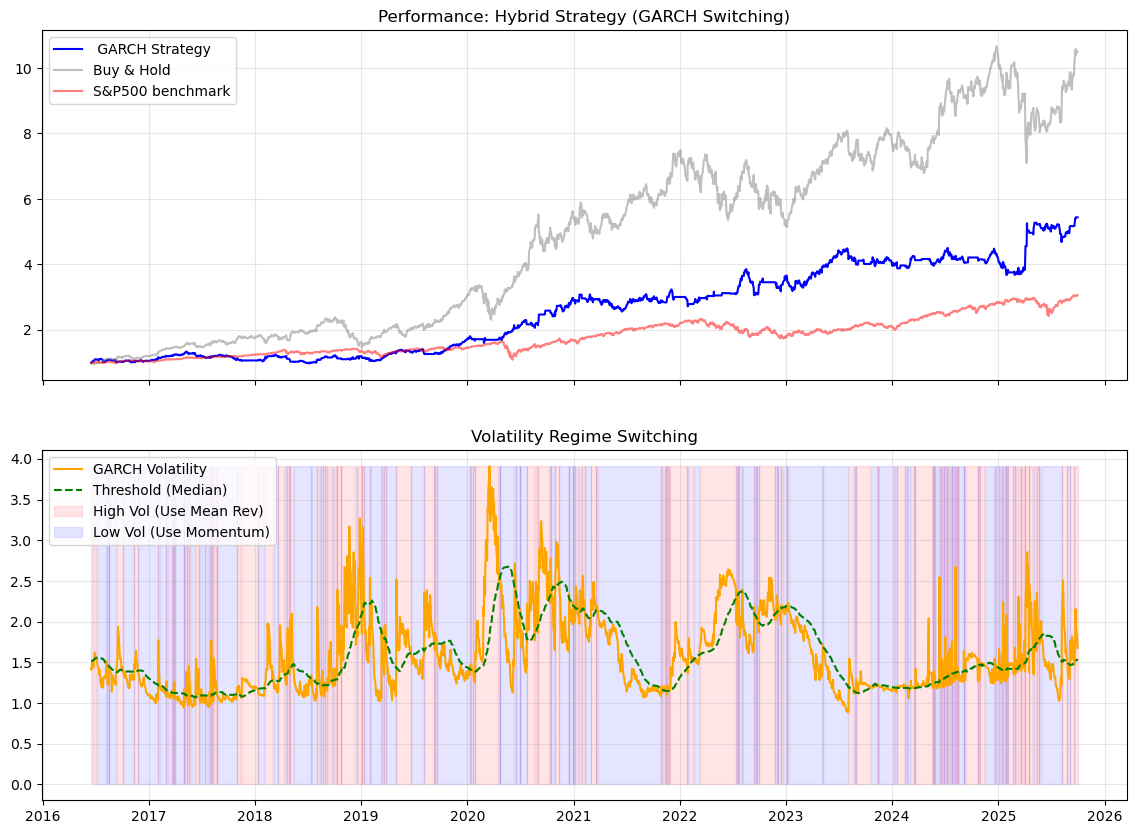

In [105]:
trade_results['trade_log_return'] = trade_results['final_signal'].shift(1) * trade_results['close_log_return']
trade_results.dropna(inplace=True)

# Cumulative Returns
trade_results['cum_S&P500'] = np.exp(df_SP500['close_log_return'].cumsum())
trade_results['cum_strategy'] = np.exp(trade_results['trade_log_return'].cumsum())
trade_results['cum_benchmark'] = np.exp(trade_results['close_log_return'].cumsum())

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ 1: Hiệu suất
ax1.plot(trade_results['date'], trade_results['cum_strategy'], label=' GARCH Strategy', color='blue')
ax1.plot(trade_results['date'], trade_results['cum_benchmark'], label='Buy & Hold', color='gray', alpha=0.5)
ax1.plot(trade_results['date'], trade_results['cum_S&P500'], label='S&P500 benchmark', color='red', alpha=0.5)
ax1.set_title('Performance: Hybrid Strategy (GARCH Switching)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Chế độ Volatility
ax2.plot(trade_results['date'], trade_results['garch_vol'], label='GARCH Volatility', color='orange')
ax2.plot(trade_results['date'], trade_results['vol_threshold'], label='Threshold (Median)', color='green', linestyle='--')
ax2.fill_between(trade_results['date'], 0, max(trade_results['garch_vol']),
                 where=trade_results['garch_vol'] > trade_results['vol_threshold'],
                 color='red', alpha=0.1, label='High Vol (Use Mean Rev)')
ax2.fill_between(trade_results['date'], 0, max(trade_results['garch_vol']),
                 where=trade_results['garch_vol'] <= trade_results['vol_threshold'],
                 color='blue', alpha=0.1, label='Low Vol (Use Momentum)')
ax2.set_title('Volatility Regime Switching')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.show()


In [106]:
import math

trade_results["is_won"] = np.where(np.sign(trade_results["trade_log_return"]) == np.sign(trade_results["close_log_return"]), 1, 0)

strategy_metrics = {
    "Win Rate": trade_results["is_won"].mean(),
    "Mean Log Return": trade_results["trade_log_return"].mean(),
    "Std Log Return": trade_results["trade_log_return"].std(),
    "Max Log Drawdown": (trade_results["cum_strategy"] - trade_results["cum_strategy"].cummax()).min(),
    "Sharpe Ratio": (trade_results["trade_log_return"].mean() / trade_results["trade_log_return"].std()) * math.sqrt(252)
}

# Metrics BENCHMARK (S&P 500)
sp500_log_ret = df_SP500["close_log_return"]
sp500_cum_ret = sp500_log_ret.cumsum()

benchmark_metrics = {
    # Win rate của thị trường là tỷ lệ số ngày tăng giá
    "Win Rate": (sp500_log_ret > 0).mean(),
    
    "Mean Log Return": sp500_log_ret.mean(),
    "Std Log Return": sp500_log_ret.std(),
    
    # Tính Drawdown cho Benchmark
    "Max Log Drawdown": (sp500_cum_ret - sp500_cum_ret.cummax()).min(),
    
    # Sharpe Ratio (Annualized)
    "Sharpe Ratio": (sp500_log_ret.mean() / sp500_log_ret.std()) * math.sqrt(252)
}

In [107]:
#  Create DataFrame
comparison_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=["Strategy", "S&P 500"])

# Transpose 
comparison_df = comparison_df.T

print(comparison_df)

                  Strategy   S&P 500
Win Rate          0.485017  0.539230
Mean Log Return   0.000725  0.000436
Std Log Return    0.013549  0.011380
Max Log Drawdown -0.828394 -0.414379
Sharpe Ratio      0.849397  0.608676


### Strategy with Stop Loss and Take Profit based on Volatility estimate by GRACH(1,1) model
- Stop loss when price hits the lower channel
- Take profit when price hits the upper channel

In [ ]:
def backtest_with_tp_sl(df, initial_capital=10000, sl_factor=2, tp_factor=3):
    cash = initial_capital
    position = 0
    entry_price = 0
    shares = 0
    trades = []
    equity_curve = []
    entry_date = None
    
    df = df.copy().sort_values('date').reset_index(drop=True)

    for i, row in df.iterrows():
        # 1. Data Setup
        price = row['close']
        high = row['high']
        low = row['low']
        current_date = row['date']
        
        vol_col = 'grach_vol' if 'grach_vol' in df.columns else 'garch_vol'
        daily_vol = (row[vol_col] / 100) * price if row[vol_col] > 0 else 0
        
        # Flag to prevent re-entering a trade immediately after SL/TP on the same bar
        just_closed = False 

        # 2. Check Exits (Stop Loss / Take Profit)
        if position != 0:
            sl_price = 0
            tp_price = 0 
            exit_price = 0
            
            # --- LONG POSITIONS ---
            if position == 1:
                sl_price = entry_price - (sl_factor * daily_vol)
                tp_price = entry_price + (tp_factor * daily_vol)
                
                # Check Low for SL first (Conservative), then High for TP
                if low <= sl_price:
                    exit_price = sl_price
                elif high >= tp_price:
                    exit_price = tp_price
                
                if exit_price != 0: # Logic triggered
                    pnl = (exit_price - entry_price) * shares
                    cash += exit_price * shares
                    trades.append({
                        'entry_price': entry_price, 'exit_price': exit_price,
                        'pnl': pnl, 'shares': shares, 'entry_date': entry_date,
                        'exit_date': current_date, 'position': 1, 'reason': 'SL/TP'
                    })
                    position = 0
                    shares = 0
                    entry_price = 0
                    just_closed = True

            # --- SHORT POSITIONS ---
            elif position == -1:
                sl_price = entry_price + (sl_factor * daily_vol)
                tp_price = entry_price - (tp_factor * daily_vol)
                
                # Check High for SL (Shorts die on Highs), Low for TP
                if high >= sl_price:
                    exit_price = sl_price
                elif low <= tp_price:
                    exit_price = tp_price
                    
                if exit_price != 0:
                    pnl = (entry_price - exit_price) * shares # Short PnL Formula
                    cost = exit_price * shares
                    cash -= cost # Repay the borrowed value
                    trades.append({
                        'entry_price': entry_price, 'exit_price': exit_price,
                        'pnl': pnl, 'shares': shares, 'entry_date': entry_date,
                        'exit_date': current_date, 'position': -1, 'reason': 'SL/TP'
                    })
                    position = 0
                    shares = 0
                    entry_price = 0
                    just_closed = True

        # 3. Check Signals (Entry / Reversal)
        # We skip this block if we 'just_closed' to avoid immediate re-entry on the same noise
        signal = row['final_signal']
        
        if not just_closed:
            # Entry logic
            if position == 0:
                if signal == 1 or signal == -1:
                    position = signal
                    entry_price = price
                    entry_date = current_date
                    
                    # Size calculation (Simple: Use all cash)
                    shares = int(cash / price) 
                    
                    if position == 1:
                        cash -= entry_price * shares
                    elif position == -1:
                        cash += entry_price * shares # Add short proceeds to cash

            # Reversal logic (Long -> Short or Short -> Long)
            elif position != 0 and signal != 0 and signal != position:
                # Close current
                exit_price = price
                if position == 1:
                    cash += exit_price * shares
                    pnl = (exit_price - entry_price) * shares
                else: # Short
                    cash -= exit_price * shares
                    pnl = (entry_price - exit_price) * shares

                trades.append({
                    'entry_price': entry_price, 'exit_price': exit_price,
                    'pnl': pnl, 'shares': shares, 'entry_date': entry_date,
                    'exit_date': current_date, 'position': position, 'reason': 'Signal Flip'
                })
                
                # Open New
                position = signal
                entry_price = price
                entry_date = current_date
                shares = int(cash / price)
                
                if position == 1:
                    cash -= entry_price * shares
                elif position == -1:
                    cash += entry_price * shares

        # 4. Track Equity
        # Mark-to-Market value: Cash + Value of Open Positions
        current_equity = cash
        if position == 1:
            current_equity += shares * price
        elif position == -1:
            current_equity -= shares * price
            
        equity_curve.append({'date': current_date, 'equity': current_equity})

    # Return results
    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve)
    return trades_df, equity_df

In [ ]:
def plot_backtest_results(equity_df, trades_df, original_df, df_sp500, vol_col='garch_vol'):
    """
    plot Equity Curve, Drawdown và Volatility Regimes.
    Compare with  Buy & Hold and Benchmark S&P 500.
    """
    data = pd.merge(original_df, equity_df, on='date', how='inner')
    
    sp500_merge = df_sp500[['date', 'close']].rename(columns={'close': 'sp500_close'})
    data = pd.merge(data, sp500_merge, on='date', how='left')
    
    data['sp500_close'] = data['sp500_close'].ffill()

    initial_equity = data['equity'].iloc[0]
    initial_price = data['close'].iloc[0]
    # 1. Buy & Hold Benchmark
    initial_price_stock = data['close'].iloc[0]
    data['benchmark_stock'] = (data['close'] / initial_price_stock) * initial_equity
    
    if data['sp500_close'].isnull().all():
        print("Cảnh báo: Không tìm thấy dữ liệu S&P 500 trùng khớp ngày.")
        data['benchmark_sp500'] = initial_equity # Fallback: đường ngang
    else:

        initial_price_sp500 = data['sp500_close'].iloc[0]
        data['benchmark_sp500'] = (data['sp500_close'] / initial_price_sp500) * initial_equity
    
    data['peak_equity'] = data['equity'].cummax()
    data['drawdown'] = (data['equity'] - data['peak_equity']) / data['peak_equity']
    
    if 'vol_threshold' not in data.columns:
        data['vol_threshold'] = data[vol_col].median()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1.5]})
    
    # --- Panel 1: Hiệu suất (Equity Curve) ---
    ax1.plot(data['date'], data['equity'], label='Hybrid Strategy (GARCH)', color='#1f77b4', linewidth=2)
    ax1.plot(data['date'], data['benchmark_stock'], label='Buy & Hold (Stock)', color='gray', alpha=0.5, linestyle='--')
    ax1.plot(data['date'], data['benchmark_sp500'], label='S&P 500 Benchmark', color='red', alpha=0.6, linewidth=1.5)
    
    # Highlight Trades
    # Filter trades that happened within the plot range
    long_entries = trades_df[trades_df['position'] == 1]
    short_entries = trades_df[trades_df['position'] == -1]
    
    # Plot entry points if not too cluttered
    if len(trades_df) < 500: 
        ax1.scatter(long_entries['entry_date'], long_entries['entry_price'] * (initial_equity/initial_price), 
                    marker='^', color='green', alpha=0.6, label='Long Entry')
        ax1.scatter(short_entries['entry_date'], short_entries['entry_price'] * (initial_equity/initial_price), 
                    marker='v', color='red', alpha=0.6, label='Short Entry')

    ax1.set_title('Performance Comparison: Strategy vs S&P 500 vs Buy&Hold')
    ax1.set_ylabel('Equity ($)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # --- Panel 2: Drawdown ---
    ax2.fill_between(data['date'], data['drawdown'], 0, color='red', alpha=0.3)
    ax2.plot(data['date'], data['drawdown'], color='red', linewidth=1)
    ax2.set_title('Strategy Drawdown')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, alpha=0.3)

    # --- Panel 3: Volatility Regimes ---
    ax3.plot(data['date'], data[vol_col], label='GARCH Volatility', color='orange', linewidth=1.5)
    ax3.plot(data['date'], data['vol_threshold'], label='Regime Threshold', color='green', linestyle='--', linewidth=1)
    
    # Tô màu nền theo chế độ Volatility
    ax3.fill_between(data['date'], 0, data[vol_col].max(), 
                     where=data[vol_col] > data['vol_threshold'],
                     color='red', alpha=0.1, label='High Vol (Mean Rev)')
    
    ax3.fill_between(data['date'], 0, data[vol_col].max(), 
                     where=data[vol_col] <= data['vol_threshold'],
                     color='blue', alpha=0.1, label='Low Vol (Momentum)')
    
    ax3.set_title('Volatility Regimes Switching')
    ax3.set_ylabel('Volatility')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [110]:
trades, equity = backtest_with_tp_sl(trade_results)

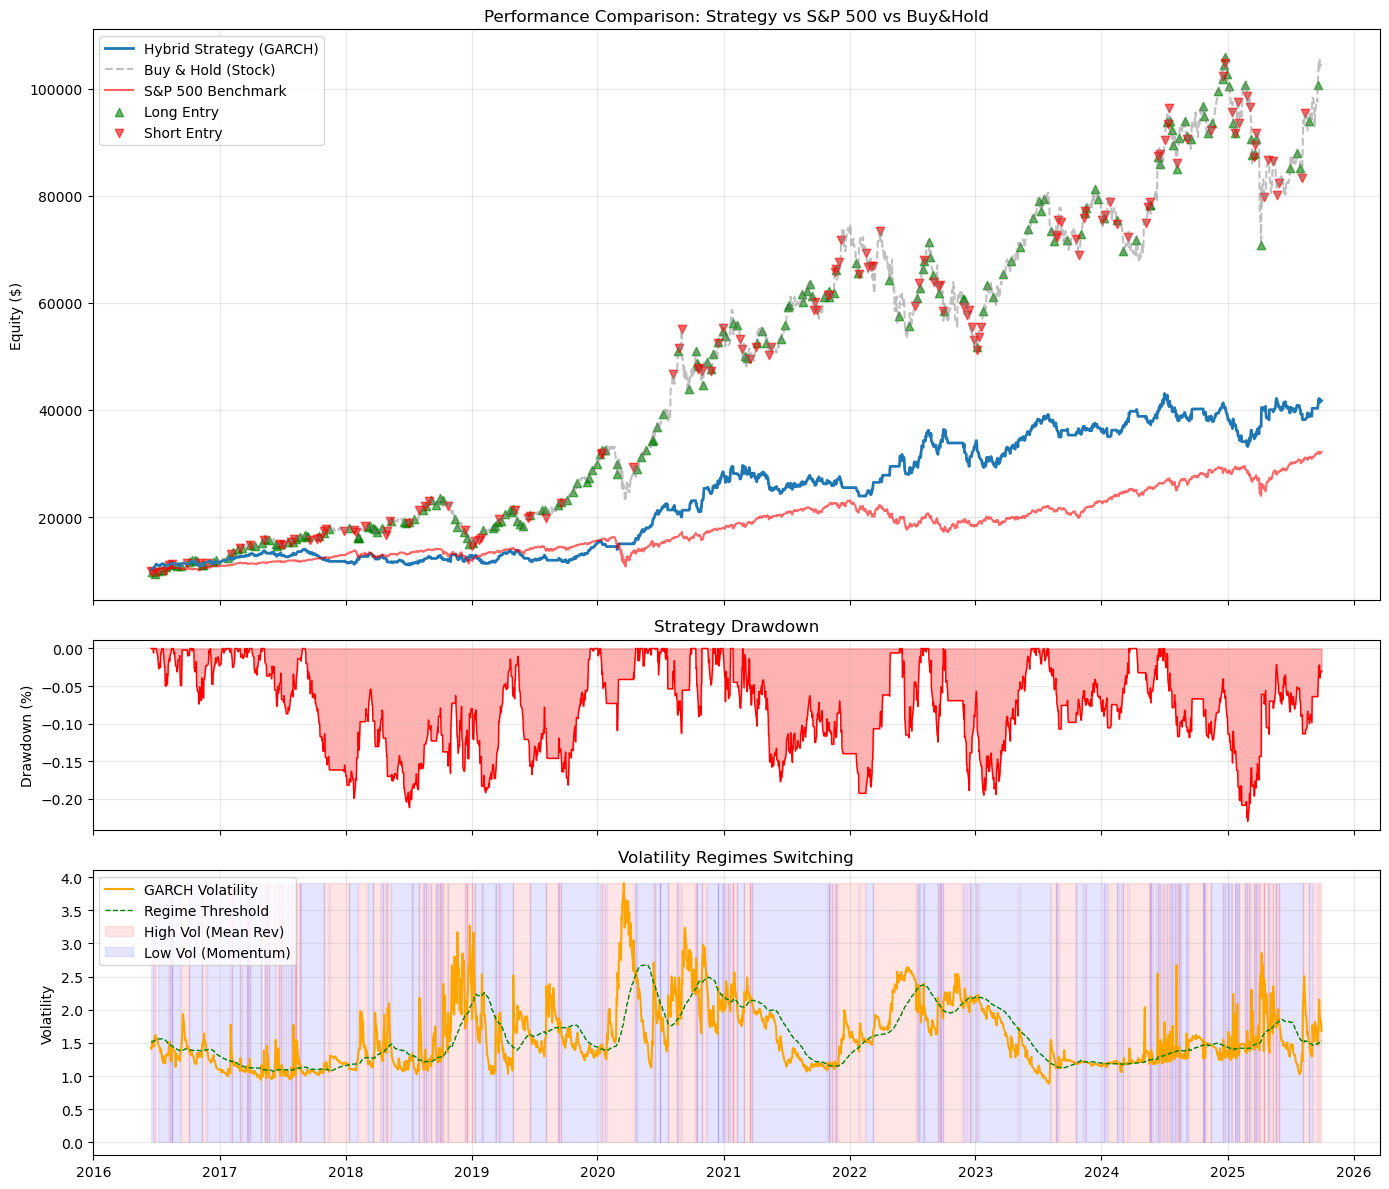

In [111]:
plot_backtest_results(equity, trades, trade_results, df_SP500)

In [ ]:
import math

def calculate_metrics(equity_df, trades_df, df_sp500):
    equity_df = equity_df.copy()
    equity_df['daily_return'] = equity_df['equity'].pct_change().fillna(0)
    
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl'] > 0])
    win_rate_strategy = winning_trades / total_trades if total_trades > 0 else 0
    
    equity_df['peak'] = equity_df['equity'].cummax()
    equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak']
    max_drawdown_strategy = equity_df['drawdown'].min()

    merged_df = pd.merge(equity_df[['date', 'daily_return']], 
                         df_sp500[['date', 'close']], 
                         on='date', how='inner')
    
    merged_df['sp500_return'] = merged_df['close'].pct_change().fillna(0)
    
    merged_df['sp500_peak'] = merged_df['close'].cummax()
    merged_df['sp500_drawdown'] = (merged_df['close'] - merged_df['sp500_peak']) / merged_df['sp500_peak']
    max_drawdown_sp500 = merged_df['sp500_drawdown'].min()
    
    metrics = {
        'Strategy': {
            'Win Rate': win_rate_strategy,
            'Total Return': (equity_df['equity'].iloc[-1] / equity_df['equity'].iloc[0]) - 1,
            'Mean Daily Return': equity_df['daily_return'].mean(),
            'Std Daily Return': equity_df['daily_return'].std(),
            'Sharpe Ratio': (equity_df['daily_return'].mean() / equity_df['daily_return'].std()) * math.sqrt(252) if equity_df['daily_return'].std() != 0 else 0,
            'Max Drawdown': max_drawdown_strategy
        },
        'S&P 500': {
            'Win Rate': (merged_df['sp500_return'] > 0).mean(), 
            'Total Return': (merged_df['close'].iloc[-1] / merged_df['close'].iloc[0]) - 1,
            'Mean Daily Return': merged_df['sp500_return'].mean(),
            'Std Daily Return': merged_df['sp500_return'].std(),
            'Sharpe Ratio': (merged_df['sp500_return'].mean() / merged_df['sp500_return'].std()) * math.sqrt(252) if merged_df['sp500_return'].std() != 0 else 0,
            'Max Drawdown': max_drawdown_sp500
        }
    }
    
    comparison_df = pd.DataFrame(metrics)
    
    return comparison_df


In [113]:
performance_table = calculate_metrics(equity, trades, df_SP500)

print(performance_table)

                   Strategy   S&P 500
Win Rate           0.485549  0.546661
Total Return       3.174475  2.218716
Mean Daily Return  0.000690  0.000568
Std Daily Return   0.012555  0.011590
Sharpe Ratio       0.872850  0.777887
Max Drawdown      -0.230039 -0.339250
